In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

def schwefel(coordinates):
    return 418.9829 * len(coordinates) - np.sum(coordinates * np.sin(np.sqrt(np.abs(coordinates))))

def sphere(individual):
    return np.sum(np.square(individual))

def generate_particle(dim, bounds, idx, func):
    position = np.random.uniform(bounds[0], bounds[1], dim)
    velocity = np.zeros(dim)
    return {
        "id": idx,
        "position": position,
        "velocity": velocity,
        "personal_best_position": np.copy(position),
        "personal_best_score": func(position),
    }

def generate_population(dim, bounds, population_size, func):
    return [generate_particle(dim, bounds, i, func) for i in range(population_size)]

def best_circ_neighbor(particles, index, neighborhood_size):
    scores = [p["personal_best_score"] for p in particles]
    neighbors = [(index + i) % len(particles) for i in range(-neighborhood_size, neighborhood_size + 1) if i != 0]
    best_idx = min(neighbors, key=lambda i: scores[i])
    return particles[best_idx]["personal_best_position"]

def save_population_to_file(particles, generation, func):
    df = pd.DataFrame([
        {
            "generation": generation,
            "id": p["id"],
            **{f"gene_{i}": p["position"][i] for i in range(len(p["position"]))}
        }
        for p in particles
    ])
    df.to_csv("population_log_PSO_" + func + ".csv", mode="a", header=not os.path.exists("population_log_PSO_" + func + ".csv"), index=False)

def pso(
    dimensions,
    population_size,
    generations,
    initial_inertia,
    final_inertia,
    func,
    bounds,
    c1, c2,
    topology="global",
    neighborhood_size=2,
    vmax_factor=0.2
):
    particles = generate_population(dimensions, bounds, population_size, func)
    vmax = vmax_factor * (bounds[1] - bounds[0])

    if os.path.exists("population_log_PSO.csv"):
        os.remove("population_log_PSO.csv")

    global_best_position = min(particles, key=lambda p: p["personal_best_score"])["personal_best_position"]
    global_best_score = min(p["personal_best_score"] for p in particles)

    best_fitnesses = []
    avg_fitnesses = []

    for gen in range(generations):
        inertia = initial_inertia - (initial_inertia - final_inertia) * gen / generations
        save_population_to_file(particles, gen, func.__name__)

        fitness_values = []

        for i, particle in enumerate(particles):
            if topology == "global":
                best_position = global_best_position
            elif topology == "ring":
                best_position = best_circ_neighbor(particles, i, neighborhood_size)

            r1 = np.random.rand(dimensions)
            r2 = np.random.rand(dimensions)

            particle["velocity"] = (
                inertia * particle["velocity"]
                + c1 * r1 * (particle["personal_best_position"] - particle["position"])
                + c2 * r2 * (best_position - particle["position"])
            )
            particle["velocity"] = np.clip(particle["velocity"], -vmax, vmax)

            particle["position"] += particle["velocity"]
            particle["position"] = np.clip(particle["position"], bounds[0], bounds[1])

            fitness = func(particle["position"])
            fitness_values.append(fitness)

            if fitness < particle["personal_best_score"]:
                particle["personal_best_score"] = fitness
                particle["personal_best_position"] = np.copy(particle["position"])

        current_best = min(particles, key=lambda p: p["personal_best_score"])
        if current_best["personal_best_score"] < global_best_score:
            global_best_score = current_best["personal_best_score"]
            global_best_position = np.copy(current_best["personal_best_position"])

        best_fitnesses.append(global_best_score)
        avg_fitnesses.append(np.mean(fitness_values))

    
    final_population = [p["position"] for p in particles]
    return final_population, best_fitnesses, avg_fitnesses

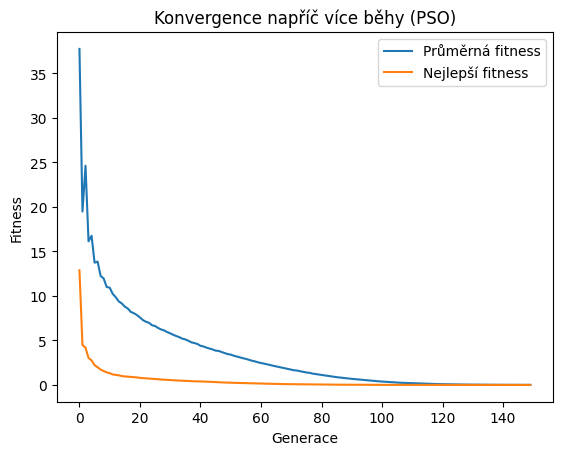

Konečná nejlepší fitness (průměr přes běhy): 4.914443496476884e-06


In [10]:
num_runs = 100
generations = 150
pop_size = 100
dimensions = 10
bounds = (-5.12, 5.12)

all_best_fitness = []
all_avg_fitness = []

for run in range(num_runs):
    #print(f"Run {run + 1}/{num_runs}")

    _, best_fitness, avg_fitness = pso(
        dimensions=dimensions,
        population_size=pop_size,
        generations=generations,
        initial_inertia=0.9,
        final_inertia=0.4,
        func=sphere,
        bounds=bounds,
        c1=2.0,
        c2=2.0,
        topology="global"
    )

    all_best_fitness.append(best_fitness)
    all_avg_fitness.append(avg_fitness)

# Převod na numpy pro výpočty
all_best_fitness = np.array(all_best_fitness)
all_avg_fitness = np.array(all_avg_fitness)

# Výpočet průměrných fitness napříč běhy
mean_best_fitness = np.mean(all_best_fitness, axis=0)
mean_avg_fitness = np.mean(all_avg_fitness, axis=0)

# Vykreslení
plt.plot(mean_avg_fitness, label="Průměrná fitness")
plt.plot(mean_best_fitness, label="Nejlepší fitness")
plt.legend()
plt.xlabel("Generace")
plt.ylabel("Fitness")
plt.title("Konvergence napříč více běhy (PSO)")
plt.show()

print("Konečná nejlepší fitness (průměr přes běhy):", mean_best_fitness[-1])


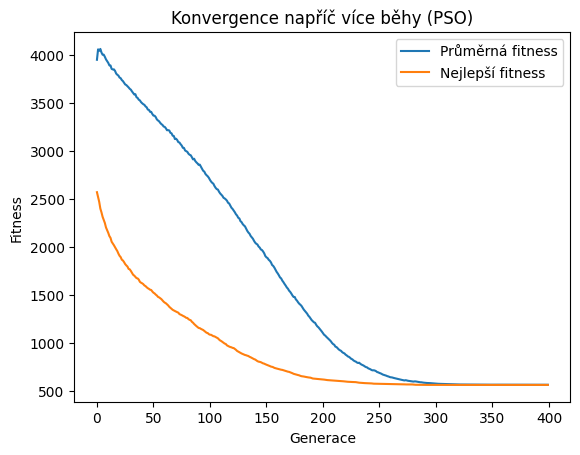

Konečná nejlepší fitness (průměr přes běhy): 563.7361176858778


In [12]:
num_runs = 100
generations = 400
pop_size = 100
dimensions = 10
bounds = (-500, 500)

all_best_fitness = []
all_avg_fitness = []

for run in range(num_runs):
    #print(f"Run {run + 1}/{num_runs}")

    _, best_fitness, avg_fitness = pso(
        dimensions=dimensions,
        population_size=pop_size,
        generations=generations,
        initial_inertia=0.9,
        final_inertia=0.4,
        func=schwefel,
        bounds=bounds,
        c1=2.0,
        c2=2.0,
        topology="global"
    )

    all_best_fitness.append(best_fitness)
    all_avg_fitness.append(avg_fitness)

# Převod na numpy pro výpočty
all_best_fitness = np.array(all_best_fitness)
all_avg_fitness = np.array(all_avg_fitness)

# Výpočet průměrných fitness napříč běhy
mean_best_fitness = np.mean(all_best_fitness, axis=0)
mean_avg_fitness = np.mean(all_avg_fitness, axis=0)

# Vykreslení
plt.plot(mean_avg_fitness, label="Průměrná fitness")
plt.plot(mean_best_fitness, label="Nejlepší fitness")
plt.legend()
plt.xlabel("Generace")
plt.ylabel("Fitness")
plt.title("Konvergence napříč více běhy (PSO)")
plt.show()

print("Konečná nejlepší fitness (průměr přes běhy):", mean_best_fitness[-1])


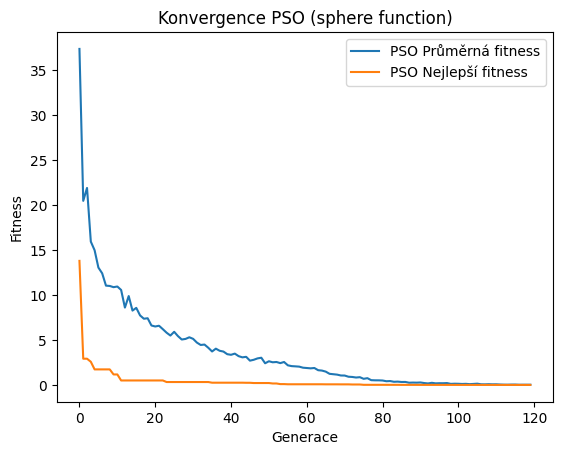

Nejlepší fitness v poslední generaci: 9.84212640416625e-05
Průměrné fitness v poslední generaci: 0.021550132597962787


In [2]:
# Parametry
generations = 120
pop_size = 100
dimensions = 10
bounds = (-5.12, 5.12)
inertia_start = 0.9
inertia_end = 0.4
c1 = 2.0
c2 = 2.0

# Spuštění jednoho běhu PSO
_, best_fitness, avg_fitness = pso(
    dimensions=dimensions,
    population_size=pop_size,
    generations=generations,
    initial_inertia=inertia_start,
    final_inertia=inertia_end,
    func=sphere,
    bounds=bounds,
    c1=c1,
    c2=c2,
    topology="global"
)

# Vykreslení konvergence
plt.plot(avg_fitness, label="PSO Průměrná fitness")
plt.plot(best_fitness, label="PSO Nejlepší fitness")
plt.legend()
plt.xlabel("Generace")
plt.ylabel("Fitness")
plt.title("Konvergence PSO (sphere function)")
plt.show()

# Výstup výsledků
print("Nejlepší fitness v poslední generaci:", best_fitness[-1])
print("Průměrné fitness v poslední generaci:", avg_fitness[-1])


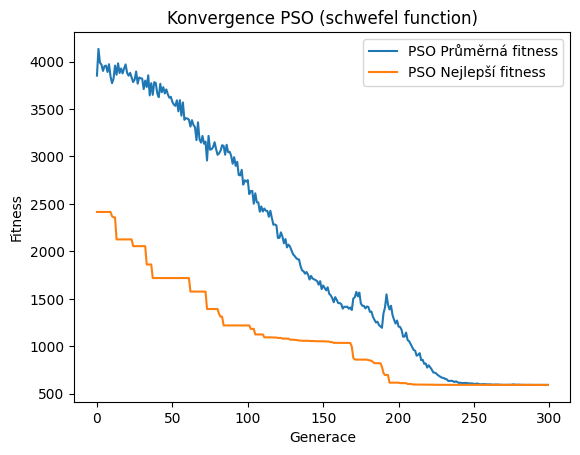

Nejlepší fitness v poslední generaci: 592.1918010460445
Průměrné fitness v poslední generaci: 592.2061601247349


In [7]:
# Parametry
generations = 300
pop_size = 100
dimensions = 10
bounds = (-500, 500)
inertia_start = 0.9
inertia_end = 0.4
c1 = 2.0
c2 = 2.0

# Spuštění jednoho běhu PSO
_, best_fitness, avg_fitness = pso(
    dimensions=dimensions,
    population_size=pop_size,
    generations=generations,
    initial_inertia=inertia_start,
    final_inertia=inertia_end,
    func=schwefel,
    bounds=bounds,
    c1=c1,
    c2=c2,
    topology="global"
)

# Vykreslení konvergence
plt.plot(avg_fitness, label="PSO Průměrná fitness")
plt.plot(best_fitness, label="PSO Nejlepší fitness")
plt.legend()
plt.xlabel("Generace")
plt.ylabel("Fitness")
plt.title("Konvergence PSO (schwefel function)")
plt.show()

# Výstup výsledků
print("Nejlepší fitness v poslední generaci:", best_fitness[-1])
print("Průměrné fitness v poslední generaci:", avg_fitness[-1])
